### Funções

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [51]:
base = pd.read_parquet('datasets/base.parquet')

In [52]:
base.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 766 entries, 0 to 765
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   file_path            766 non-null    object
 1   id_produto           766 non-null    object
 2   grupo_produto        766 non-null    object
 3   file_name            766 non-null    object
 4   link                 766 non-null    object
 5   PRODUTOS             766 non-null    object
 6   CARACTERISTICAS      766 non-null    object
 7   LOCALIZACAO_ESTAMPA  766 non-null    object
 8   COR_PREDOMINANTE     766 non-null    object
 9   DECOTE_OU_GOLA       515 non-null    object
 10  COMPRIMENTO_SAIA     216 non-null    object
 11  AMARRACAO            748 non-null    object
 12  ZOOM_ESTAMPA         766 non-null    object
 13  COMPRIMENTO_MANGA    533 non-null    object
 14  ESTILO               766 non-null    object
 15  TIPO_MANGA           533 non-null    object
 16  TIPO_CIN

### Puxando embeddings

In [53]:
# Puxando embeddings
df_embs = pd.read_parquet('datasets/img_embeddings.parquet')

In [54]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Função que aplica LDA: recebe um df, as colunas desse df que contêm os embeddings e o número de componentes que se deseja obter
def apply_lda(df, colunas, n_components=2, lda=None, colum_target='COR_PREDOMINANTE'):
    """
    Aplica LDA nos embeddings para redução de dimensionalidade com base na coluna 'COR_PREDOMINANTE',
    ignorando valores nulos na coluna de target e retornando um novo DataFrame com as colunas desejadas.
    """
    df_filtered = df.copy()

    if not lda:
        # Inicializando o modelo LDA
        lda = LinearDiscriminantAnalysis(n_components=n_components)

        # Filtrando os dados para remover nulos na coluna 'COR_PREDOMINANTE'
        df_filtered = df_filtered.dropna(subset=[f'{colum_target}'])

        # Treinando o modelo e transformando os dados
        componentes = lda.fit_transform(df_filtered[colunas], df_filtered[f'{colum_target}'])

        # Criando um novo DataFrame com as colunas desejadas
        df_lda = df_filtered[['id_produto', f'{colum_target}']].copy()

    else:
        componentes = lda.transform(df_filtered[colunas])

        # Criando um novo DataFrame com as colunas desejadas
        df_lda = df_filtered[['id_produto']].copy()

    for i in range(n_components):
        df_lda[f'EMB_LDA_{i}'] = componentes[:, i]

    return df_lda, lda

In [55]:
# Função para plotar os componentes reduzidos com cores definidas por um dicionário
def plot_cores(df, cor_column='COR_PREDOMINANTE', reducer='LDA', color_dict=None, show=True):
    """
    Plota os componentes reduzidos colorindo os pontos com base em um dicionário de cores.
    """

    # Setando componente x e y conforme o reducer
    component_x, component_y = f'EMB_{reducer}_0', f'EMB_{reducer}_1'

    # Filtrando apenas as linhas que possuem valores válidos (sem NaN) nos componentes
    df_plot = df.dropna(subset=[component_x, component_y, cor_column])

    # Se o dicionário de cores não for fornecido, gerar um dicionário de cores padrão
    if color_dict is None:
        unique_colors = df_plot[cor_column].unique()
        color_dict = {color: plt.cm.tab20(i / len(unique_colors)) for i, color in enumerate(unique_colors)}

    # Removendo linhas com cores não mapeadas no dicionário de cores
    df_plot = df_plot[df_plot[cor_column].isin(color_dict.keys())]

    # Iterar por cada cor e plotar os pontos
    for cor, color_value in color_dict.items():
        subset = df_plot[df_plot[cor_column] == cor]
        
        # Adicionar borda preta se a cor for branca
        edge_color = 'black' if color_value == '#FFFFFF' else color_value

        plt.scatter(
            subset[component_x],
            subset[component_y],
            color=color_value,
            edgecolor=edge_color,  # Define a cor da borda
            linewidth=0.5 if color_value in ['#FFFFFF', '#F8F4E3'] else 0,  # Define a largura da borda para pontos brancos
            alpha=0.7,
            label=cor
        )

    # Botando a legenda deslocada para fora do gráfico
    plt.legend(title=f"{cor_column}", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xlabel(component_x)
    plt.ylabel(component_y)
    plt.title(f"Componentes {reducer} com cores de {cor_column}")
    if show:
        plt.show()

In [56]:
from umap.umap_ import UMAP

def calcular_centroides(df, colunas, target_column):
    """
    Calcula os centróides para cada categoria em 'target_column' com base nas colunas fornecidas.
    Retorna um DataFrame com os centróides e a categoria correspondente.
    """
    # 1. Calcular os centróides para cada {target_column}
    df_centroides = df.drop(columns={'id_produto'}).groupby(f'{target_column}').mean().reset_index()

    # 2. Adicionar a coluna 'id_produto' aos centróides
    df_centroides['id_produto'] = df_centroides[f'{target_column}'].apply(lambda x: f'CLUSTER_{x}')

    # 3. Adicionar uma coluna para identificar os centróides
    df_centroides['is_centroid'] = True
    
    df['is_centroid'] = False  # Para os dados originais

    # 4. Concatenar os dados originais com os centróides
    df_combined = pd.concat([df, df_centroides], ignore_index=True)

    return df_combined

In [57]:
import plotly.graph_objects as go

def plot_clusters_with_centroids(
    df_combined, 
    target_column, 
    embedding_columns, 
    color_dict=None, 
    title="Visualização de Clusters com Centróides", 
    apply_umap=False, 
    umap_params=None,
    is_1d=False
):
    """
    Cria um gráfico de dispersão interativo com os clusters e seus centróides.
    
    Parâmetros:
    - df_combined: DataFrame contendo os dados originais e os centróides.
    - target_column: Nome da coluna que contém as categorias dos clusters.
    - embedding_columns: Lista com os nomes das colunas de embeddings.
    - color_dict: Dicionário com as cores específicas para cada categoria. Default: cores automáticas.
    - title: Título do gráfico. Default: "Visualização de Clusters com Centróides".
    - apply_umap: Booleano indicando se UMAP deve ser aplicado. Default: False.
    - umap_params: Dicionário com parâmetros para o UMAP. Default: None.
    - is_1d: Booleano indicando se os dados são unidimensionais. Default: False.
    
    Retorna:
    - Objeto Figure do Plotly.
    """
    # Aplicar UMAP se solicitado
    if apply_umap:
        umap_params = umap_params or {'n_neighbors': 15, 'n_components': 2, 'random_state': 42}
        umap = UMAP(**umap_params)
        
        embeddings = df_combined[embedding_columns].values
        umap_embeddings = umap.fit_transform(embeddings)

        # Adicionar os embeddings reduzidos ao DataFrame
        df_combined['UMAP_0'] = umap_embeddings[:, 0]
        if not is_1d:
            df_combined['UMAP_1'] = umap_embeddings[:, 1]

        # Ajustar as colunas para o gráfico
        embedding_columns = ['UMAP_0'] if is_1d else ['UMAP_0', 'UMAP_1']

    # Separar dados originais e centróides
    df_original = df_combined[df_combined['is_centroid'] == False].copy()
    df_original['Tipo'] = 'Original'

    df_centroids = df_combined[df_combined['is_centroid'] == True].copy()
    df_centroids['Tipo'] = 'Centróide'

    # Gerar um dicionário de cores se não fornecido
    if color_dict is None:
        categorias = df_original[target_column].unique()
        # Setando paleta de cores do tableau
        color_palette = [
            '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
            '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf',
            '#ff9896', '#aec7e8', '#ffbb78', '#98df8a'
        ]
        color_dict = {categoria: color_palette[i % len(color_palette)] for i, categoria in enumerate(categorias)}

    # Criação do gráfico com Plotly
    fig = go.Figure()

    # Adicionar os pontos dos dados originais por categoria
    for categoria, cor in color_dict.items():
        subset = df_original[df_original[target_column] == categoria]
        fig.add_trace(go.Scatter(
            x=subset[embedding_columns[0]],
            y=[0] * len(subset) if is_1d else subset[embedding_columns[1]],
            mode='markers',
            marker=dict(color=cor, size=8, line=dict(width=1, color='black')),
            name=f'{categoria}',
            hoverinfo='text',
            text=subset['id_produto']
        ))

    # Adicionar os centróides com cor fixa
    fig.add_trace(go.Scatter(
        x=df_centroids[embedding_columns[0]],
        y=[0] * len(df_centroids) if is_1d else df_centroids[embedding_columns[1]],
        mode='markers',
        marker=dict(color='red', symbol='x', size=10, line=dict(width=0.5)),
        name='Centróides',
        hoverinfo='text',
        text=df_centroids['id_produto']
    ))

    # Configuração do layout
    fig.update_layout(
        title=title,
        xaxis_title=f'{embedding_columns[0]}',
        yaxis_title='' if is_1d else f'{embedding_columns[1]}',
        legend_title='Legenda',
        template='plotly_white',
        hovermode='closest'
    )

    if is_1d:
        fig.update_layout(
            yaxis=dict(showgrid=False, showticklabels=False, zeroline=False)
        )

    return fig

### 1° passo: construir espaço de LISO vs ESTAMPADO

In [58]:
# Lendo df_estampa
df_estampa = pd.read_parquet('datasets/PILAR_ESTAMPA/df_estampa.parquet')

In [59]:
# Renomear id para id_produto
df_estampa.rename(columns={'id': 'id_produto'}, inplace=True)

In [60]:
# Merge dos embeddings com os dados de vestidos
df_estampa = df_estampa.merge(df_embs, on='id_produto', how='inner')

In [61]:
# Merge com base pra puxar informações do id
df_estampa = df_estampa.merge(base[['id_produto', 'file_name', 'file_path']], on='id_produto', how='inner')

In [62]:
df_estampa['ESTAMPADO'].value_counts()

False    640
True     126
Name: ESTAMPADO, dtype: int64

In [63]:
df_estampa['ESTAMPADO'].value_counts()

False    640
True     126
Name: ESTAMPADO, dtype: int64

In [64]:
emb_columns = [col for col in df_estampa.columns if col.startswith('emb_img_')]

In [65]:
# Aplicando LDA 
df_lda_estampado, lda_estampado = apply_lda(df_estampa, emb_columns, n_components=1, colum_target='ESTAMPADO')

In [66]:
lda_estampado

LinearDiscriminantAnalysis(n_components=1)

In [67]:
# direcao_de_ser_estampado = lda_estampado.scalings_.shape

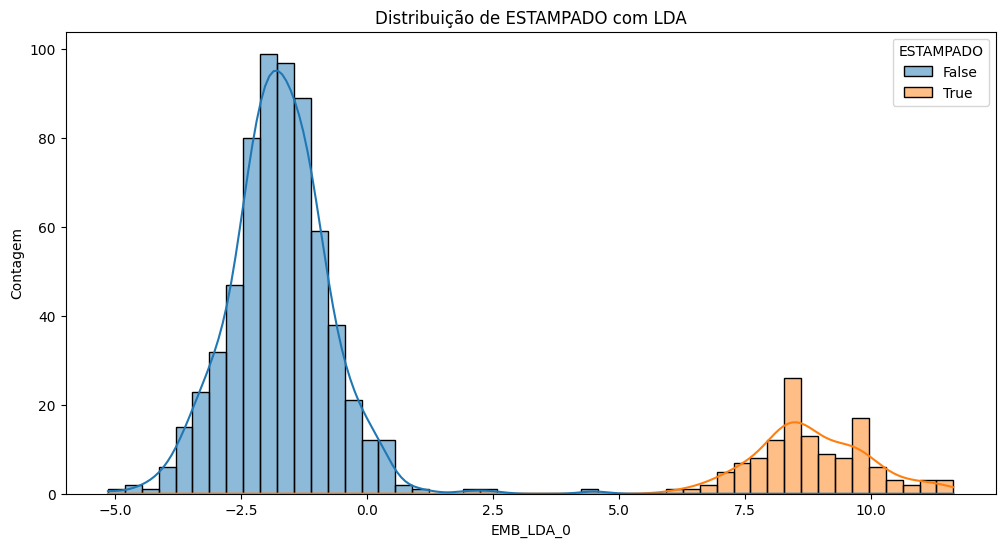

In [68]:
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.histplot(
    data=df_lda_estampado,
    x='EMB_LDA_0',
    hue='ESTAMPADO',
    kde=True,  # Para adicionar uma curva de densidade
    bins=50  # Número de bins
)
    
# Adicionar rótulos e título
plt.title('Distribuição de ESTAMPADO com LDA')
plt.xlabel('EMB_LDA_0')
plt.ylabel('Contagem')
plt.show()

In [69]:
colunas_lda = [col for col in df_lda_estampado.columns if col.startswith('EMB_LDA')]

# Calcular os centróides de df_lda_comprimento_saia
df_combined_estampado = calcular_centroides(df_lda_estampado, colunas_lda, 'ESTAMPADO')

In [70]:
df_combined_estampado

id_produto  ESTAMPADO  EMB_LDA_0  is_centroid
0    07-20-6782-04526      False  -0.572688        False
1    07-20-6944-09792       True   8.690871        False
2    07-20-6832-09792       True  10.568962        False
3    07-20-7076-09805       True   8.951198        False
4     07-20-6821-0300      False  -0.286603        False
..                ...        ...        ...          ...
763   03-01-1624-0005      False  -0.146512        False
764  03-04-0439-09040      False  -3.408315        False
765  03-04-0431-09041      False  -1.751969        False
766     CLUSTER_False      False  -1.740536         True
767      CLUSTER_True       True   8.840819         True

[768 rows x 4 columns]

In [71]:
# Lista das colunas de embeddings de alta dimensionalidade
embedding_columns = [col for col in df_lda_estampado.columns if col.startswith('EMB_LDA')]

fig = plot_clusters_with_centroids(
    df_combined=df_combined_estampado,
    target_column='ESTAMPADO',
    embedding_columns=embedding_columns,
    color_dict=None,
    title="Visualização Unidimensional",
    apply_umap=False,
    is_1d=True
)
fig.show()


### 2° passo: construir espaço das estampas

In [72]:
df_estampados = df_estampa[df_estampa['ESTAMPADO'] == True].copy()

In [73]:
df_estampados

id_produto                                          descricao  \
1    07-20-6944-09792      vestido-de-malha-lurex-midi-abstrado-sem-alca   
2    07-20-6832-09792  vestido-de-georgette-pesado-longo-franzido-est...   
3    07-20-7076-09805   vestido-de-georgette-leve-midi-estampado-de-alca   
9    07-20-7072-09845  vestido-de-georgette-leve-curto-estampado-deco...   
13   07-20-7022-09817                  vestido-midi-estampado-com-decote   
..                ...                                                ...   
719  52-05-1516-09557                camisa-alongada-com-botoes-est-onca   
721  52-05-1565-09544  camisa-de-georgette-leve-polo-manga-curta-esta...   
729  52-05-1541-09601       camisa-cropped-polo-ampla-decote-v-estampada   
731  52-05-1563-09546  camisa-de-georgette-pesado-lenco-manga-ampla-e...   
740  52-05-1536-09563      camisa-de-georgette-com-manga-curta-estampado   

                                   cor  ESTAMPADO ESTAMPA_CADASTRO  emb_img_0  \
1         est-abstrato-silhuetas-yucca       True         abstrato   0.257689   
2         est-abstrato-silhuetas-yucca       True         abstrato   0.262626   
3            est-floral-vagalume-color       True           floral   0.077555   
9                   est-onca-leve-flan       True             onca   0.305138   
13      est-pois-ciclos-golden-e-musgo       True              poa   0.273455   
..                                 ...        ...              ...        ...   
719    est-onca-aquarela-forte-color-p       True             onca  -0.148225   
721     est-floral-garden-rum-e-vivo-m       True           floral   0.189123   
729                    est-geo-caminho       True       geometrico   0.153404   
731  est-floral-geometrico-block-color       True           floral  -0.036801   
740      est-pois-tri-preto-e-exotique       True              poa   0.296233   

     emb_img_1  emb_img_2  emb_img_3  emb_img_4  ...  emb_img_504  \
1     0.030505  -0.222474   0.503372  -0.379572  ...     0.254457   
2     0.074574  -0.124754   0.404772  -0.508334  ...     0.087691   
3    -0.137274   0.083672   0.502234  -0.347559  ...     0.909467   
9    -0.409740  -0.084350   0.572314  -0.213605  ...     0.340335   
13   -0.154599   0.073932   0.348211  -0.595500  ...     0.606148   
..         ...        ...        ...        ...  ...          ...   
719  -0.338818  -0.249542   0.127206  -0.020000  ...    -0.171887   
721   0.154968   0.080838   0.038848  -0.017937  ...     0.456824   
729   0.022664  -0.135747   0.119862   0.039452  ...     0.250366   
731   0.492269  -0.043226   0.107752   0.080259  ...     0.858236   
740   0.200493  -0.147597   0.175321  -0.057859  ...     0.667414   

     emb_img_505  emb_img_506  emb_img_507  emb_img_508  emb_img_509  \
1       0.016213    -0.051857    -0.019263     0.143287     0.600517   
2       0.252806    -0.113489     0.043947     0.221147     0.868243   
3      -0.064646    -0.101649    -0.270959     0.234643     0.972271   
9       0.431390    -0.057373    -0.284500     0.344939     0.504290   
13      0.089069     0.012021    -0.352329     0.102348     0.388866   
..           ...          ...          ...          ...          ...   
719    -0.139304    -0.294821    -0.296876     0.248659     0.278227   
721     0.079807    -0.173173    -0.226601     0.350130     0.510533   
729     0.229614    -0.158387    -0.128443     0.056539     0.604755   
731    -0.018657     0.023858    -0.411295     0.524204     0.510692   
740    -0.141833    -0.009114    -0.102347     0.233556     0.857816   

     emb_img_510  emb_img_511  \
1      -0.165040     0.279477   
2      -0.057524     0.465791   
3      -0.257417     0.331307   
9      -0.259795    -0.018702   
13     -0.097670     0.164136   
..           ...          ...   
719    -0.386326     0.463192   
721     0.215038     0.337530   
729    -0.074187     0.473394   
731     0.218533    -0.008571   
740    -0.217888     0.455604   

                                  

In [74]:
emb_columns = [col for col in df_estampados.columns if col.startswith('emb_img_')]

In [75]:
df_estampados['ESTAMPA_CADASTRO'].value_counts()

floral        31
onca          27
poa           21
geometrico    14
listra         9
cobra          8
abstrato       7
xadrez         5
leopardo       2
folhagem       2
Name: ESTAMPA_CADASTRO, dtype: int64

In [76]:
# Aplicando LDA 
df_lda_estampa, lda_estampa = apply_lda(df_estampados, emb_columns, n_components=9, colum_target='ESTAMPA_CADASTRO')

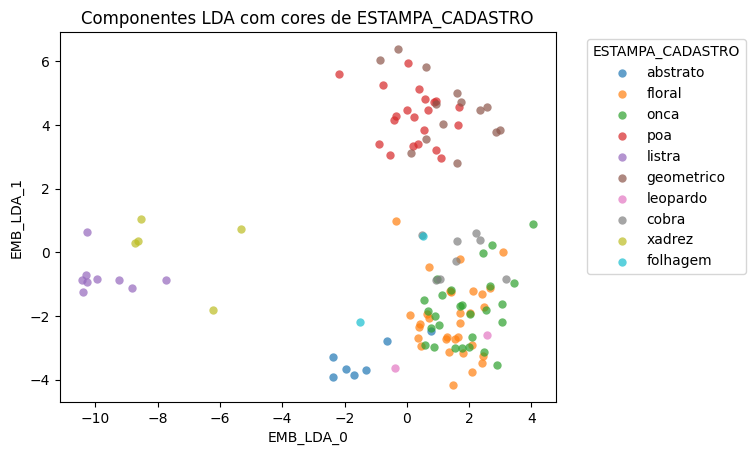

In [77]:
# Plotando os componentes reduzidos
plot_cores(df_lda_estampa, cor_column='ESTAMPA_CADASTRO', reducer='LDA')

In [78]:
colunas_lda = [col for col in df_lda_estampa.columns if col.startswith('EMB_LDA')]

# Calcular os centróides de df_lda_estampa
df_combined_estampa = calcular_centroides(df_lda_estampa, colunas_lda, 'ESTAMPA_CADASTRO')

In [79]:
# Lista das colunas de embeddings de alta dimensionalidade
embedding_columns = [col for col in df_lda_estampa.columns if col.startswith('EMB_LDA')]

fig = plot_clusters_with_centroids(
    df_combined=df_combined_estampa,
    target_column='ESTAMPA_CADASTRO',
    embedding_columns=embedding_columns,
    color_dict=None,
    title="Visualização com UMAP",
    apply_umap=True,
    is_1d=False
)
fig.show()


c:\Users\Cole\AppData\Local\Programs\Python\Python311\Lib\site-packages\umap\umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



#### Testando busca

In [80]:
from sentence_transformers import SentenceTransformer, util
from PIL import Image, ImageFile
import requests
import torch

# We use the original clip-ViT-B-32 for encoding images
img_model = SentenceTransformer('clip-ViT-B-32')

# Our text embedding model is aligned to the img_model and maps 50+
# languages to the same vector space
text_model = SentenceTransformer('sentence-transformers/clip-ViT-B-32-multilingual-v1')

In [81]:
import os

# Gerando os embeddings das imagens teste
pasta = "teste_images_est"

# Criando lista com as image_paths da pasta
image_paths = [os.path.join(pasta, path).replace('\\','/') for path in os.listdir(pasta)]

# Criando um df_color com os nomes das imagens
df_teste = pd.DataFrame(image_paths, columns=["image_path"])

In [82]:
# Now we load and encode the images
def load_image(url_or_path):
    if url_or_path.startswith("http://") or url_or_path.startswith("https://"):
        return Image.open(requests.get(url_or_path, stream=True).raw)
    else:
        return Image.open(url_or_path)

file_names = df_teste['image_path'].values
images = [load_image(img) for img in file_names]
img_embeddings = img_model.encode(images)

img_embeddings

array([[ 0.13773817, -0.02874207, -0.16563526, ...,  0.79826   ,
         0.05048802,  0.09640896],
       [ 0.28220153, -0.02417591, -0.10736406, ...,  0.46468005,
        -0.16907284,  0.14003585],
       [ 0.01593399, -0.01290508,  0.08765367, ...,  0.46371883,
         0.09719289, -0.00938809],
       ...,
       [ 0.03531731, -0.41758204, -0.06961253, ...,  0.40265095,
        -0.2245236 ,  0.24885969],
       [ 0.12211426,  0.06844866, -0.05305152, ...,  0.7042111 ,
         0.03351029,  0.27614862],
       [ 0.07622055,  0.08899803, -0.27048182, ...,  0.6793731 ,
         0.07155737,  0.31138134]], dtype=float32)

In [83]:
# Adicionando embeddings em df_teste
emb_dict = {}

for i, emb in enumerate(img_embeddings):
    emb_id = df_teste.iloc[i]["image_path"]
    emb_dict[emb_id] = emb

df_teste_embs = pd.DataFrame(emb_dict).T

# Renomeando as colunas de embedding para emb_i
df_teste_embs.columns = [f'emb_img_{i}' for i in range(df_teste_embs.shape[1])]

In [84]:
lda_estampa

LinearDiscriminantAnalysis(n_components=9)

In [85]:
colunas_embs = [col for col in df_teste_embs.columns if 'emb_img' in col]

In [86]:
df_teste_embs.reset_index(inplace=True)

# Renomear index para id_produto
df_teste_embs.rename(columns={'index': 'id_produto'}, inplace=True)

In [87]:
# Aplicando mesmo LDA usado no treinamento
img_embs_teste_lda, lda_estampa = apply_lda(df_teste_embs, colunas_embs, 9, lda=lda_estampa)

In [88]:
img_embs_teste_lda

id_produto  EMB_LDA_0  EMB_LDA_1  EMB_LDA_2  \
0    teste_images_est/abstrato.png   2.914277  -4.776124   1.805480   
1       teste_images_est/cobra.png   1.906406  -4.397586  -4.698885   
2      teste_images_est/floral.png   1.559252   0.224245   2.863533   
3      teste_images_est/listra.png  -6.195219   2.274036   1.104419   
4        teste_images_est/onca.png   1.458749  -0.759434  -4.358423   
5         teste_images_est/poa.png   1.055046   5.235185   0.619030   
6  teste_images_est/saia_cobra.png   0.770564  -1.754146  -0.871397   
7    teste_images_est/tropical.png   1.802123  -2.889206   1.969061   
8      teste_images_est/xadrez.png  -7.832692   3.657469  -1.138620   

   EMB_LDA_3  EMB_LDA_4  EMB_LDA_5  EMB_LDA_6  EMB_LDA_7  EMB_LDA_8  
0  -0.057413  -0.996683   3.224829  -0.555134   3.609111   0.588863  
1  -1.564611   3.522238   1.819943   0.727360  -2.169241   1.957505  
2   2.011693  -2.222320  -2.855261   2.071626  -1.730680  -0.303467  
3   4.915974   1.783426  -1.795822   1.375804  -1.242921   2.642244  
4   1.311293  -1.079835  -2.720245   0.993470  -0.093939  -0.362767  
5  -0.096661   0.010859   3.933341  -2.435364   2.511776   1.530017  
6  -4.104502   3.560066   3.096113  -4.322298   0.763141   2.639466  
7  -1.325011   2.440191  -0.890371   1.845979   0.101604  -1.781358  
8  -3.702383   0.548247   0.984385  -1.992640   0.200899   4.097752

Dimensões de euclidean_dist: torch.Size([9, 126])
Imagem de Teste: teste_images_est/abstrato.png


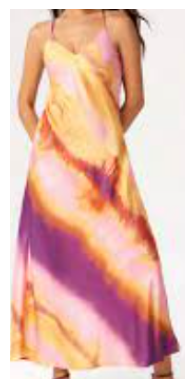

Similaridade (ID do produto): 07-20-6607-09548 - Distância Euclidiana: 5.45


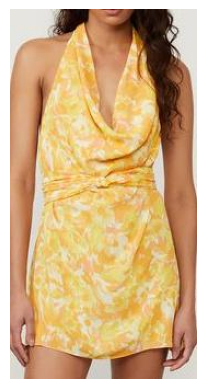

Similaridade (ID do produto): 07-20-6827-09822 - Distância Euclidiana: 5.53


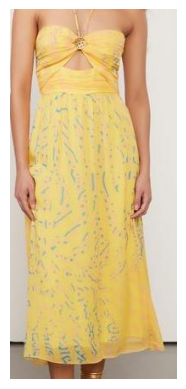

Similaridade (ID do produto): 25-34-2095-09831 - Distância Euclidiana: 5.79


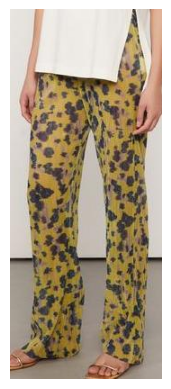


--------------------------------------------------

Imagem de Teste: teste_images_est/cobra.png


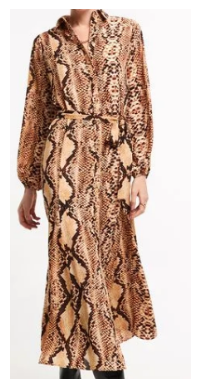

Similaridade (ID do produto): 07-20-6541-09621 - Distância Euclidiana: 4.71


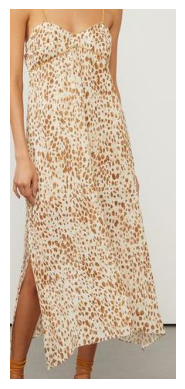

Similaridade (ID do produto): 07-20-7071-09845 - Distância Euclidiana: 4.87


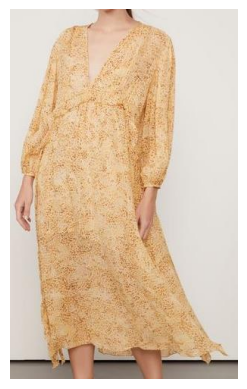

Similaridade (ID do produto): 52-06-0698-09660 - Distância Euclidiana: 5.17


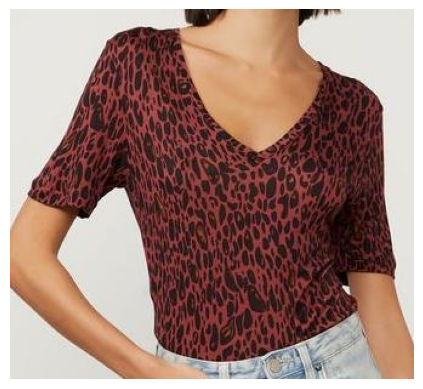


--------------------------------------------------

Imagem de Teste: teste_images_est/floral.png


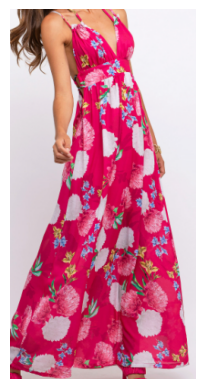

Similaridade (ID do produto): 07-20-6604-09548 - Distância Euclidiana: 3.05


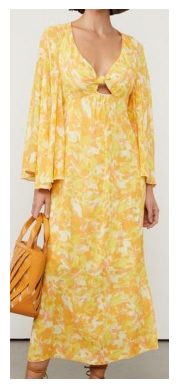

Similaridade (ID do produto): 07-20-6617-09550 - Distância Euclidiana: 3.95


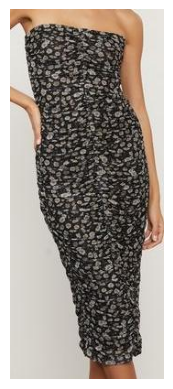

Similaridade (ID do produto): 25-34-1761-09541 - Distância Euclidiana: 4.00


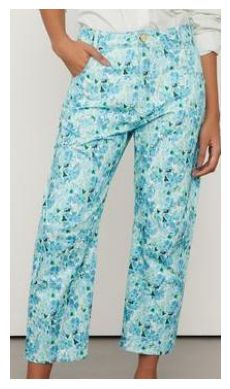


--------------------------------------------------

Imagem de Teste: teste_images_est/listra.png


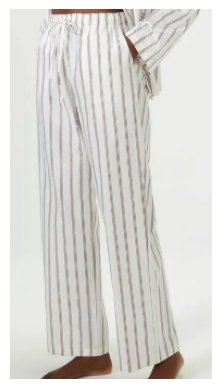

Similaridade (ID do produto): 07-20-6597-09556 - Distância Euclidiana: 5.97


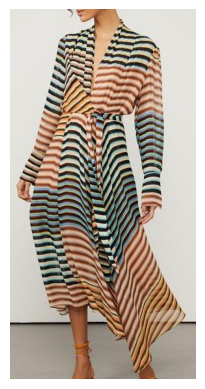

Similaridade (ID do produto): 07-20-6348-09612 - Distância Euclidiana: 6.01


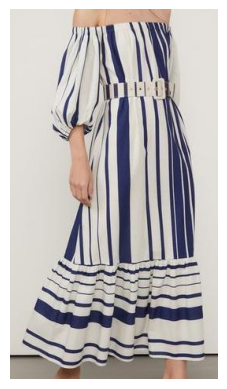

Similaridade (ID do produto): 07-20-6418-09618 - Distância Euclidiana: 6.05


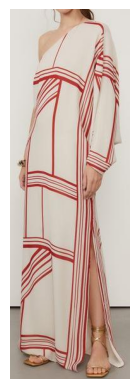


--------------------------------------------------

Imagem de Teste: teste_images_est/onca.png


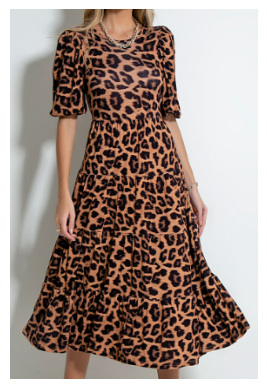

Similaridade (ID do produto): 07-20-6612-09558 - Distância Euclidiana: 3.07


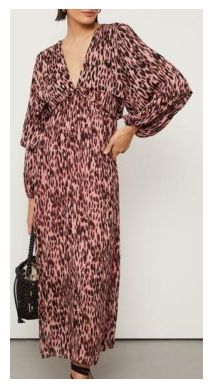

Similaridade (ID do produto): 07-20-6699-09744 - Distância Euclidiana: 3.23


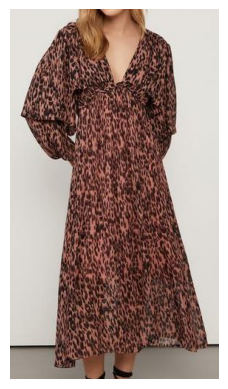

Similaridade (ID do produto): 07-20-6542-09621 - Distância Euclidiana: 3.28


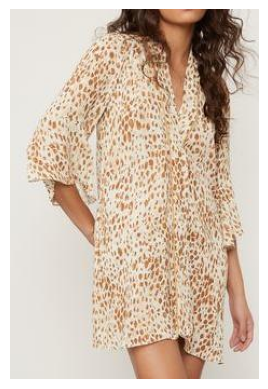


--------------------------------------------------

Imagem de Teste: teste_images_est/poa.png


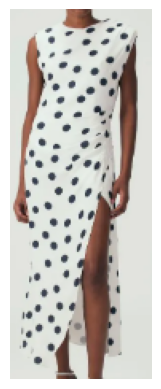

Similaridade (ID do produto): 07-20-7034-09819 - Distância Euclidiana: 3.93


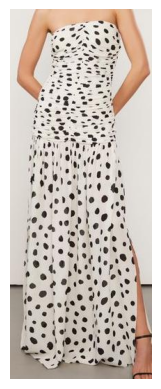

Similaridade (ID do produto): 07-20-6594-09561 - Distância Euclidiana: 4.98


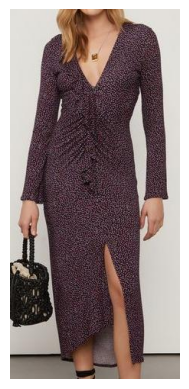

Similaridade (ID do produto): 52-13-5471-09563 - Distância Euclidiana: 5.30


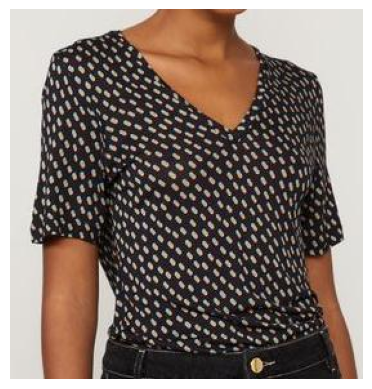


--------------------------------------------------

Imagem de Teste: teste_images_est/saia_cobra.png


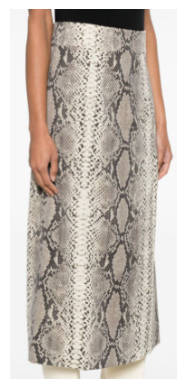

Similaridade (ID do produto): 52-06-0639-09538 - Distância Euclidiana: 5.75


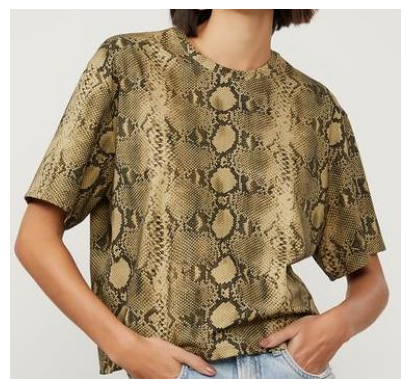

Similaridade (ID do produto): 07-20-6347-09538 - Distância Euclidiana: 6.27


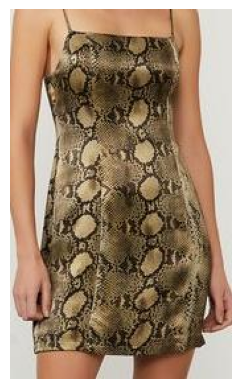

Similaridade (ID do produto): 52-13-5469-09539 - Distância Euclidiana: 6.94


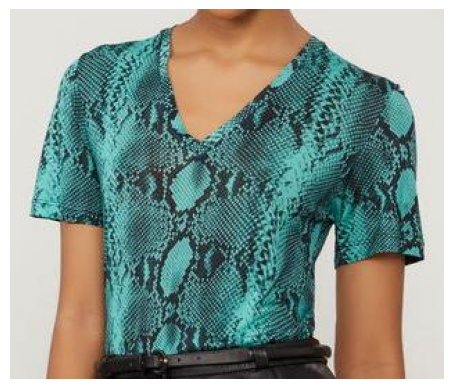


--------------------------------------------------

Imagem de Teste: teste_images_est/tropical.png


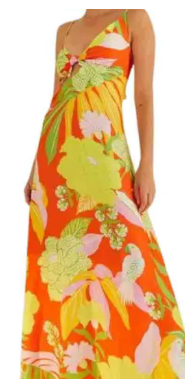

Similaridade (ID do produto): 07-20-6578-09596 - Distância Euclidiana: 1.85


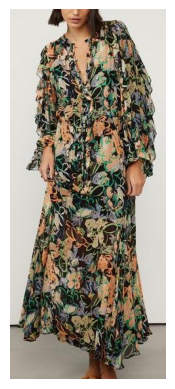

Similaridade (ID do produto): 07-20-6607-09548 - Distância Euclidiana: 2.94


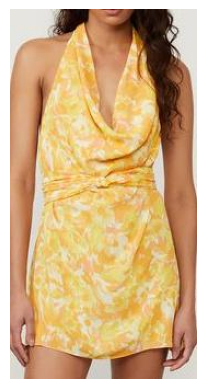

Similaridade (ID do produto): 07-20-6413-09542 - Distância Euclidiana: 3.53


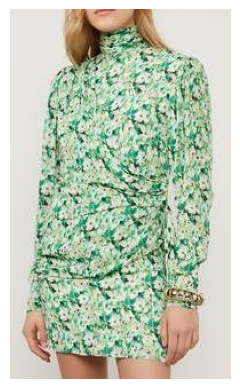


--------------------------------------------------

Imagem de Teste: teste_images_est/xadrez.png


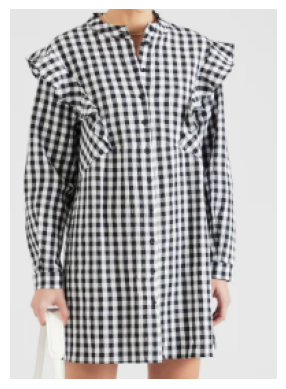

Similaridade (ID do produto): 07-20-6618-09634 - Distância Euclidiana: 7.18


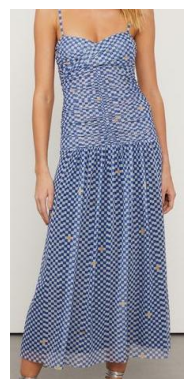

Similaridade (ID do produto): 07-20-6382-09607 - Distância Euclidiana: 8.74


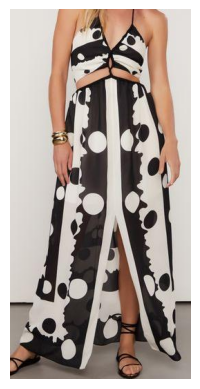

Similaridade (ID do produto): 07-20-6348-09612 - Distância Euclidiana: 8.80


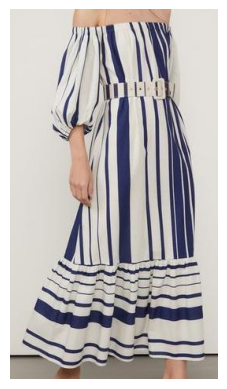


--------------------------------------------------



In [89]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image  # Para carregar imagens

def plot_image(image_path):
    """
    Função para plotar uma imagem a partir de um caminho.
    """
    img = Image.open(image_path)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

# Garantir que os dados estão no formato tensor
img_embs_teste = torch.tensor(img_embs_teste_lda[colunas_lda].values)
img_embs_completo = torch.tensor(df_lda_estampa[colunas_lda].values)

# Calcular distância euclidiana
euclidean_dist = torch.cdist(img_embs_teste, img_embs_completo, p=2)

# Verificar as dimensões
print(f"Dimensões de euclidean_dist: {euclidean_dist.shape}")  # Deve ser (num_test, num_dataset)

# Para cada imagem teste, retornando as 3 imagens mais similares
for i, distances in enumerate(euclidean_dist):
    print(f"Imagem de Teste: {df_teste.iloc[i]['image_path']}")
    plot_image(df_teste.iloc[i]['image_path'])
    
    # Garantir que distances esteja no CPU antes de converter para NumPy
    if isinstance(distances, torch.Tensor):
        distances = distances.cpu().numpy()
    
    # Obter os 3 índices com menores distâncias (mais similares)
    top_3_indices = distances.argsort()[:3]
    
    for idx in top_3_indices:
        similar_id = df_lda_estampa.iloc[idx]['id_produto']
        similar_score = distances[idx]
        print(f"Similaridade (ID do produto): {similar_id} - Distância Euclidiana: {similar_score:.2f}")
        plot_image(df_estampa.loc[df_estampa['id_produto'] == similar_id]['file_path'].values[0])
    
    print("\n" + "-"*50 + "\n")


Dimensões de euclidean_dist: torch.Size([9, 10])
Imagem de Teste: teste_images_est/abstrato.png


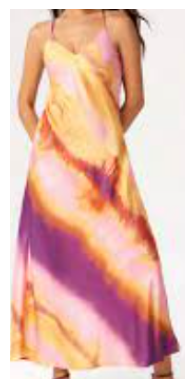

Centróide: CLUSTER_abstrato - Distância Euclidiana: 6.20
Centróide: CLUSTER_floral - Distância Euclidiana: 6.83
Centróide: CLUSTER_onca - Distância Euclidiana: 8.17

--------------------------------------------------

Imagem de Teste: teste_images_est/cobra.png


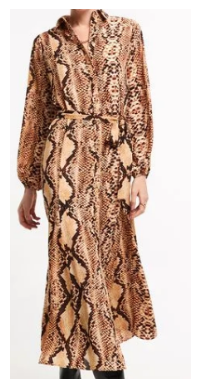

Centróide: CLUSTER_onca - Distância Euclidiana: 6.35
Centróide: CLUSTER_cobra - Distância Euclidiana: 7.44
Centróide: CLUSTER_floral - Distância Euclidiana: 9.81

--------------------------------------------------

Imagem de Teste: teste_images_est/floral.png


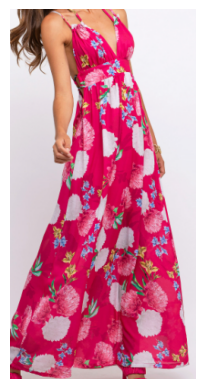

Centróide: CLUSTER_floral - Distância Euclidiana: 4.39
Centróide: CLUSTER_geometrico - Distância Euclidiana: 6.79
Centróide: CLUSTER_poa - Distância Euclidiana: 7.92

--------------------------------------------------

Imagem de Teste: teste_images_est/listra.png


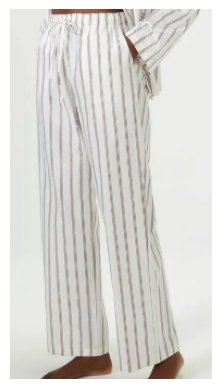

Centróide: CLUSTER_listra - Distância Euclidiana: 6.29
Centróide: CLUSTER_geometrico - Distância Euclidiana: 9.88
Centróide: CLUSTER_poa - Distância Euclidiana: 9.94

--------------------------------------------------

Imagem de Teste: teste_images_est/onca.png


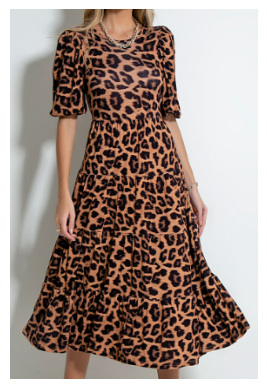

Centróide: CLUSTER_onca - Distância Euclidiana: 3.53
Centróide: CLUSTER_floral - Distância Euclidiana: 7.23
Centróide: CLUSTER_poa - Distância Euclidiana: 7.66

--------------------------------------------------

Imagem de Teste: teste_images_est/poa.png


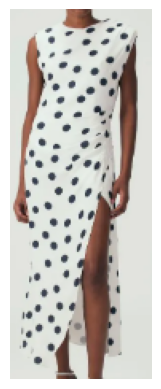

Centróide: CLUSTER_poa - Distância Euclidiana: 5.68
Centróide: CLUSTER_geometrico - Distância Euclidiana: 6.16
Centróide: CLUSTER_abstrato - Distância Euclidiana: 9.90

--------------------------------------------------

Imagem de Teste: teste_images_est/saia_cobra.png


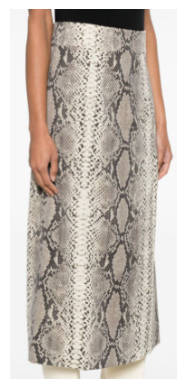

Centróide: CLUSTER_cobra - Distância Euclidiana: 6.90
Centróide: CLUSTER_leopardo - Distância Euclidiana: 9.15
Centróide: CLUSTER_onca - Distância Euclidiana: 9.17

--------------------------------------------------

Imagem de Teste: teste_images_est/tropical.png


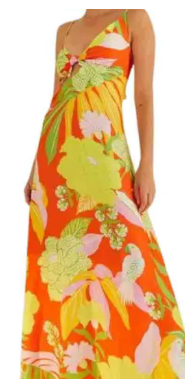

Centróide: CLUSTER_floral - Distância Euclidiana: 3.86
Centróide: CLUSTER_cobra - Distância Euclidiana: 6.07
Centróide: CLUSTER_onca - Distância Euclidiana: 7.37

--------------------------------------------------

Imagem de Teste: teste_images_est/xadrez.png


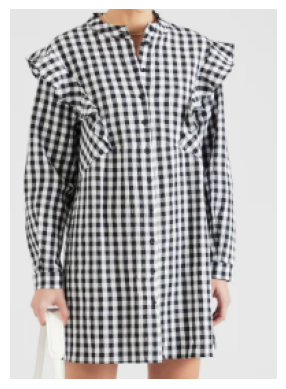

Centróide: CLUSTER_xadrez - Distância Euclidiana: 9.08
Centróide: CLUSTER_listra - Distância Euclidiana: 9.57
Centróide: CLUSTER_poa - Distância Euclidiana: 10.85

--------------------------------------------------



In [90]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

# Função para exibir imagens
def plot_image(image_path):
    """
    Função para plotar uma imagem a partir de um caminho.
    """
    img = Image.open(image_path)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

# Certifique-se de converter os dados para tensores PyTorch
img_embs_teste = torch.tensor(img_embs_teste_lda[colunas_lda].values)
img_embs_centroides = torch.tensor(
    df_combined_estampa[df_combined_estampa['is_centroid'] == True][colunas_lda].values
)

# Calcular distância euclidiana
euclidean_dist = torch.cdist(img_embs_teste, img_embs_centroides, p=2)

# Verificar as dimensões
print(f"Dimensões de euclidean_dist: {euclidean_dist.shape}")  # Deve ser (num_test, num_centroids)

# Para cada imagem de teste, calcular a distância com cada centróide
for i, distances in enumerate(euclidean_dist):
    print(f"Imagem de Teste: {df_teste.iloc[i]['image_path']}")
    plot_image(df_teste.iloc[i]['image_path'])  # Exibir a imagem de teste
    
    # Garantir que distances esteja no CPU antes de converter para NumPy
    if isinstance(distances, torch.Tensor):
        distances = distances.cpu().numpy()

    # Obter o índice com menor distância
    top_index = distances.argmin()
    second_top_index = distances.argsort()[1]
    third_top_index = distances.argsort()[2]

    for idx in [top_index, second_top_index, third_top_index]:
        similar_id = df_combined_estampa[df_combined_estampa['is_centroid'] == True].iloc[idx]['id_produto']
        similar_score = distances[idx]
        print(f"Centróide: {similar_id} - Distância Euclidiana: {similar_score:.2f}")
    # # Obter o ID do centróide mais próximo e a distância correspondente
    # similar_id = df_combined_estampa[df_combined_estampa['is_centroid'] == True].iloc[top_index]['id_produto']
    # similar_distance = distances[top_index]
    
    # print(f"Centróide mais próximo: {similar_id} - Distância Euclidiana: {similar_distance:.2f}")
    print("\n" + "-"*50 + "\n")


### Teste: Subtrair projeção

In [91]:
from sentence_transformers import SentenceTransformer, util
import requests
import torch

# We use the original clip-ViT-B-32 for encoding images
img_model = SentenceTransformer('clip-ViT-B-32')

# Our text embedding model is aligned to the img_model and maps 50+
# languages to the same vector space
text_model = SentenceTransformer('sentence-transformers/clip-ViT-B-32-multilingual-v1')

In [92]:
lda_estampado

LinearDiscriminantAnalysis(n_components=1)

In [93]:
direcao_de_ser_estampado = lda_estampado.scalings_

In [94]:
direcao_de_ser_estampado.shape

(512, 1)

In [95]:
from PIL import Image, ImageFile

def load_image(url_or_path):
    if url_or_path.startswith("http://") or url_or_path.startswith("https://"):
        return Image.open(requests.get(url_or_path, stream=True).raw)
    else:
        return Image.open(url_or_path)

In [96]:
# Load the image
saia_estampa = load_image('saia_estampado.png')
vestido_estampa = load_image('midi_estampado.png')
vestido_liso = load_image('midi_liso.png')

In [97]:
# Gero os embeddings das imagens
saia_estampa_emb = img_model.encode(saia_estampa)
vestido_estampa_emb = img_model.encode(vestido_estampa)
vestido_liso_emb = img_model.encode(vestido_liso)

In [98]:
# from sklearn.metrics.pairwise import cosine_similarity

# # Printando a similaridade de cosseno de cada par
# print("Similaridade de cosseno entre saia_estampa e vestido_estampa:", cosine_similarity([saia_estampa_emb], [vestido_estampa_emb])[0][0])
# print("Similaridade de cosseno entre saia_estampa e vestido_liso:", cosine_similarity([saia_estampa_emb], [vestido_liso_emb])[0][0])
# print("Similaridade de cosseno entre vestido_estampa e vestido_liso:", cosine_similarity([vestido_estampa_emb], [vestido_liso_emb])[0][0])



Agora vamos testar a subtração da projeção de um vetor em relação a outro.

In [99]:
# direcao_de_ser_estampado tem dimensão (512 x C-1), onde C é o número de classes do lda

# Normalize os vetores da base
B = direcao_de_ser_estampado
B = B / np.linalg.norm(B, axis=0)

C = lda_estampa.scalings_
C = C / np.linalg.norm(C, axis=0)

# Projeção para remover viés de cor
def remove_bias(X, B):
    # Projeta X na base B e remove a projeção
    projection = B @ np.linalg.inv(B.T @ B) @ B.T @ X.T
    return (X.T - projection).T

def remove_all_biases(X, list_bias):
    # Remove todos os vetores de viés
    for bias in list_bias:
        X = remove_bias(X, bias)
    return X

In [102]:
# Novo subespaço sem viés de estampa
saia_estampa_emb_novo = remove_all_biases(saia_estampa_emb, [B, C])
vestido_estampa_emb_novo = remove_all_biases(vestido_estampa_emb, [B, C])
vestido_liso_emb_novo = remove_all_biases(vestido_liso_emb, [B, C])

In [103]:
from sklearn.metrics.pairwise import cosine_similarity

# Printando a similaridade de cosseno de cada par
print("Similaridade de cosseno entre saia_estampa e vestido_estampa:", cosine_similarity([saia_estampa_emb], [vestido_estampa_emb])[0][0])
print("Similaridade de cosseno entre saia_estampa e vestido_liso:", cosine_similarity([saia_estampa_emb], [vestido_liso_emb])[0][0])
print("Similaridade de cosseno entre vestido_estampa e vestido_liso:", cosine_similarity([vestido_estampa_emb], [vestido_liso_emb])[0][0])



Similaridade de cosseno entre saia_estampa e vestido_estampa: 0.79796237
Similaridade de cosseno entre saia_estampa e vestido_liso: 0.7594849
Similaridade de cosseno entre vestido_estampa e vestido_liso: 0.8384502


In [104]:
# Printando a similaridade de cosseno de cada par
print("Similaridade de cosseno entre saia_estampa e vestido_estampa:", cosine_similarity([saia_estampa_emb_novo], [vestido_estampa_emb_novo])[0][0])
print("Similaridade de cosseno entre saia_estampa e vestido_liso:", cosine_similarity([saia_estampa_emb_novo], [vestido_liso_emb_novo])[0][0])
print("Similaridade de cosseno entre vestido_estampa e vestido_liso:", cosine_similarity([vestido_estampa_emb_novo], [vestido_liso_emb_novo])[0][0])


Similaridade de cosseno entre saia_estampa e vestido_estampa: 0.8016239209745533
Similaridade de cosseno entre saia_estampa e vestido_liso: 0.7626912987916954
Similaridade de cosseno entre vestido_estampa e vestido_liso: 0.8395929162789578


In [106]:
# Subtraindo as similaridades de cosseno de cada roupa
similaridade_saia_vestido_novo = cosine_similarity([saia_estampa_emb_novo], [vestido_estampa_emb_novo])[0][0]
similaridade_saia_liso_novo = cosine_similarity([saia_estampa_emb_novo], [vestido_liso_emb_novo])[0][0]
similaridade_vestido_liso_novo = cosine_similarity([vestido_estampa_emb_novo], [vestido_liso_emb_novo])[0][0]

similaridade_saia_vestido = cosine_similarity([saia_estampa_emb], [vestido_estampa_emb])[0][0]
similaridade_saia_liso = cosine_similarity([saia_estampa_emb], [vestido_liso_emb])[0][0]
similaridade_vestido_liso = cosine_similarity([vestido_estampa_emb], [vestido_liso_emb])[0][0]

print("Diferença de similaridade de cosseno entre saia_estampa e vestido_estampa:", similaridade_saia_vestido - similaridade_saia_vestido_novo)
print("Diferença de similaridade de cosseno entre saia_estampa e vestido_liso:", similaridade_saia_liso - similaridade_saia_liso_novo)
print("Diferença de similaridade de cosseno entre vestido_estampa e vestido_liso:", similaridade_vestido_liso - similaridade_vestido_liso_novo)

Diferença de similaridade de cosseno entre saia_estampa e vestido_estampa: -0.00366155343991581
Diferença de similaridade de cosseno entre saia_estampa e vestido_liso: -0.0032064116685874833
Diferença de similaridade de cosseno entre vestido_estampa e vestido_liso: -0.0011427228738064565
